In [1]:
import sys

sys.path.insert(0,'../code')

In [2]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
from models.interpretation import ImageInterpretationNet
from datamodules.image_classification import CIFAR10DataModule
from datamodules.transformations import UnNest
from attributions.grad_cam import grad_cam
from attributions.attention_rollout import attention_rollout
from attributions.chefer import chefer_attributions
from matplotlib import pyplot as plt
from utils.plot import smoothen, draw_mask_on_image, draw_heatmap_on_image, unnormalize

/home/angelos/anaconda3/envs/dl2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Sample Images and Model

In [3]:
# Load pre-trained Transformer
vit = ViTForImageClassification.from_pretrained("tanlq/vit-base-patch16-224-in21k-finetuned-cifar10")
vit.eval()

# Load images
feature_extractor=ViTFeatureExtractor.from_pretrained(
    "tanlq/vit-base-patch16-224-in21k-finetuned-cifar10", return_tensors="pt"
)
feature_extractor = UnNest(feature_extractor)

dm = CIFAR10DataModule(feature_extractor=feature_extractor, batch_size=800)
dm.prepare_data()
dm.setup('test')
dt = iter(dm.test_dataloader())
images, labels = next(dt)

indices = [235, 330, 67, 760, 227, 141, 29, 56, 80, 170]

images, labels = images[indices], labels[indices]
rgb_images = [img.permute(1, 2, 0) for img in unnormalize(images)]

Files already downloaded and verified
Files already downloaded and verified


### Compute GradCAM attributions

In [4]:
gradcam_masks = grad_cam(images, vit)

### Compute Chefer's attributions

In [7]:
chefer_masks = [chefer_attributions(vit, img, label) for img, label in zip(images, labels)]

### Compute Attention Rollout attributions

In [8]:
# Get attentions from images
attentions = vit(images, output_attentions=True).attentions

# Compute attention rollout masks
rollout_masks = attention_rollout(images=images, vit=vit)

### Compute DiffMask attributions

In [9]:
# Create interpretation model
diffmask = ImageInterpretationNet.load_from_checkpoint('../checkpoints/diffmask.ckpt')
diffmask.set_vision_transformer(vit)

# Compute diffmasks
diff_masks = diffmask.get_mask(images)["mask"].detach()

### Visualize results

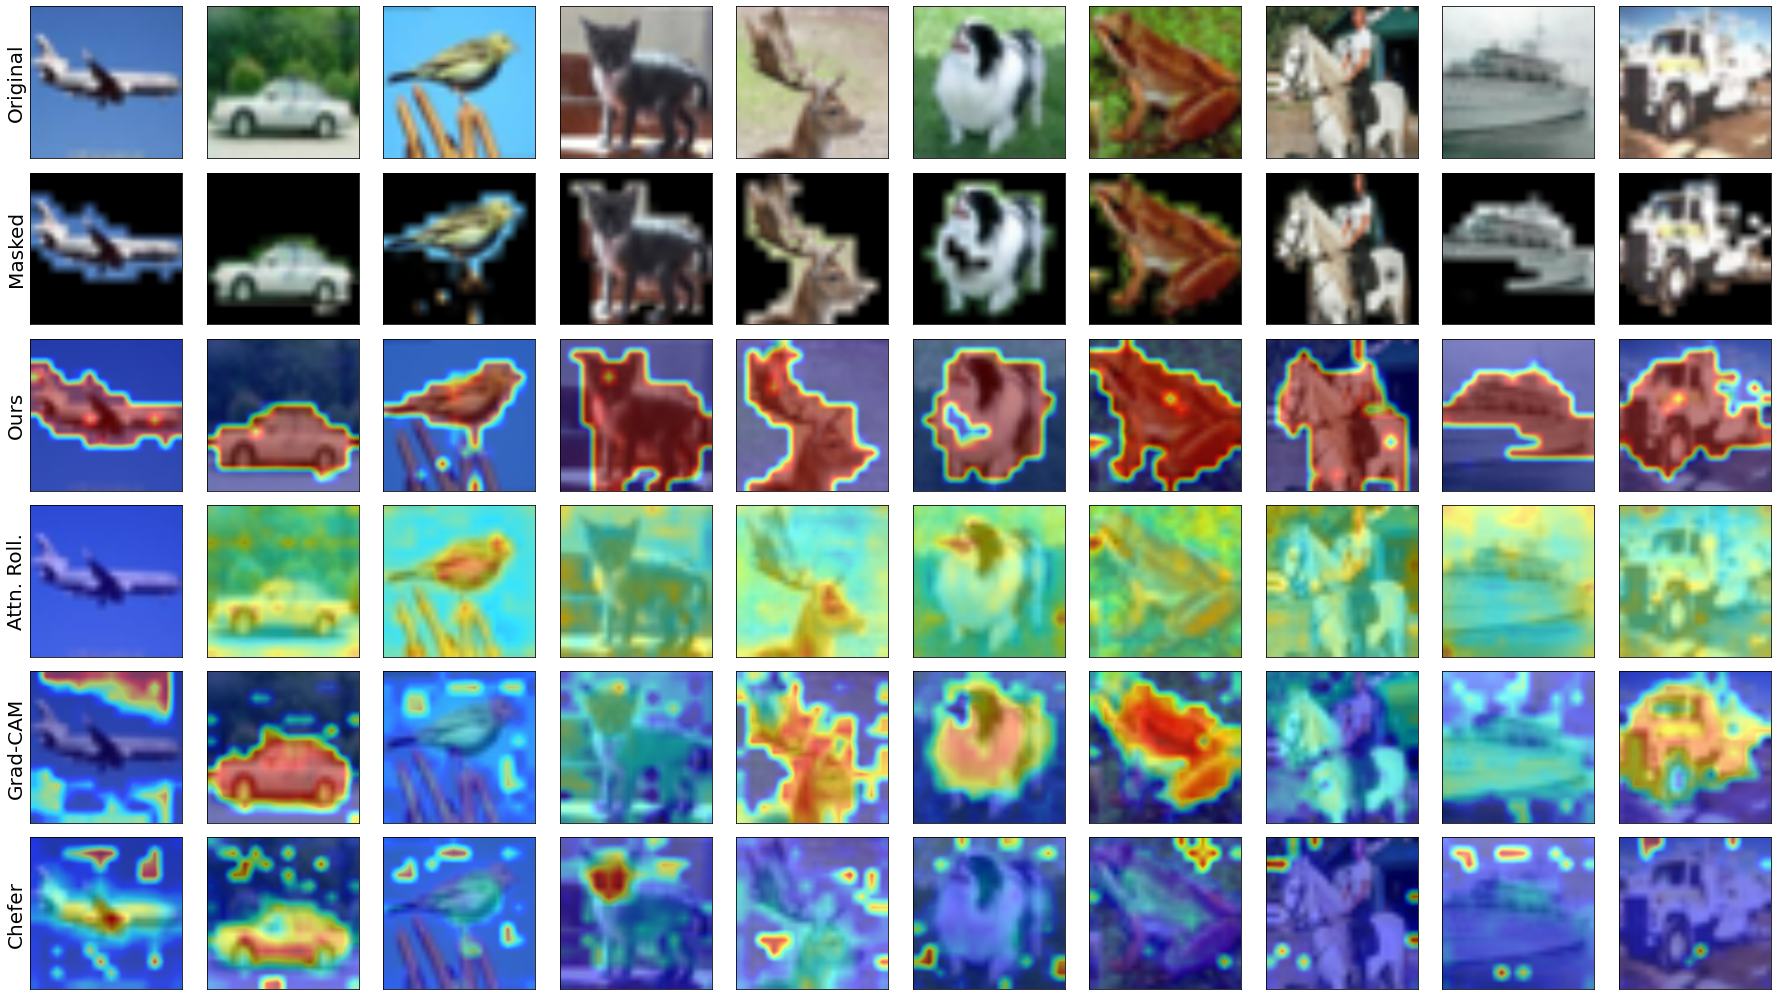

In [17]:
draw_mask = lambda image, mask: draw_mask_on_image(image.permute(2, 0, 1), mask).permute(1, 2, 0).clip(0, 1).numpy()
draw_heatmap = lambda image, mask: draw_heatmap_on_image(image.permute(2, 0, 1), mask).permute(1, 2, 0).clip(0, 1).numpy()

fig, ax = plt.subplots(6, 10, figsize=(25, 14))

# Remove axes
for i in range(6):
    for j in range(10):
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])

font_size = 20
for i in range(10):
    # Original image
    if i == 0:
        ax[0, i].set_ylabel("Original", fontsize=font_size)
#         ax[1, i].set_ylabel("Attn. Roll.", fontsize=font_size)
#         ax[2, i].set_ylabel("Grad-CAM", fontsize=font_size)
#         ax[3, i].set_ylabel("Chefer", fontsize=font_size)
        ax[1, i].set_ylabel("Masked", fontsize=font_size)
        ax[2, i].set_ylabel("Ours", fontsize=font_size)
        ax[3, i].set_ylabel("Attn. Roll.", fontsize=font_size)
        ax[4, i].set_ylabel("Grad-CAM", fontsize=font_size)
        ax[5, i].set_ylabel("Chefer", fontsize=font_size)

        
    ax[0, i].imshow(rgb_images[i])
    
#     ax[1, i].imshow(draw_mask(rgb_images[i], rollout_masks[i]))
#     ax[2, i].imshow(draw_mask(rgb_images[i], gradcam_masks[i]))
#     ax[3, i].imshow(draw_mask(rgb_images[i], chefer_masks[i]))
    ax[1, i].imshow(draw_mask(rgb_images[i], smoothen(diff_masks[i].detach())))
    
    ax[2, i].imshow(draw_heatmap(rgb_images[i], smoothen(diff_masks[i].detach())))
    ax[3, i].imshow(draw_heatmap(rgb_images[i], smoothen(rollout_masks[i])))
    ax[4, i].imshow(draw_heatmap(rgb_images[i], gradcam_masks[i]))
    ax[5, i].imshow(draw_heatmap(rgb_images[i], chefer_masks[i]))

fig.tight_layout()
fig.savefig("qualitative_comparison.jpg", dpi=300)